In [1]:
import os
import time
from datetime import date

import numpy as np
import polars as pl
import torch
import sys

# LTB modules (expected to exist in your repo)
from modeling_module.data_loader import MultiPartExoDataModule
from modeling_module.training.model_trainers.total_train import run_total_train_weekly

# optional
import matplotlib.pyplot as plt

'''
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
https://developer.nvidia.com/cuda-12-8-0-download-archive
'''

MAC_DIR = "/Users/igwanhyeong/PycharmProjects/ts_forecaster_lib/raw_data/"
WINDOW_DIR = "C:/Users/USER/PycharmProjects/ts_forecaster_lib/raw_data/"

DIR = WINDOW_DIR if sys.platform == "win32" else MAC_DIR
device = "cuda" if torch.cuda.is_available() else "cpu"

print("DIR:", DIR)
print("device:", device)
if device == "cuda":
    print("cuda:", torch.version.cuda, "gpu_count:", torch.cuda.device_count())

DIR: C:/Users/USER/PycharmProjects/ts_forecaster_lib/raw_data/
device: cuda
cuda: 12.8 gpu_count: 1


In [2]:
df = pl.read_parquet(DIR + 'train_data/walmart_best_feature_train.parquet')
df

unique_id,date_idx,date,y,exo_is_holiday,exo_temperature,exo_fuel_price,exo_cpi,exo_unemployment,exo_markdown_sum,exo_markdown1,exo_markdown2,exo_markdown3,exo_markdown4,exo_markdown5,exo_markdown1_isnull,exo_markdown2_isnull,exo_markdown3_isnull,exo_markdown4_isnull,exo_markdown5_isnull,exo_p_y_lag_1w,exo_p_y_lag_2w,exo_p_y_lag_52w,exo_p_y_rollmean_4w,exo_p_y_rollmean_12w,exo_p_y_rollstd_4w,exo_p_weeks_since_holiday,exo_p_temperature,exo_p_fuel_price,exo_p_cpi,exo_p_unemployment,exo_p_markdown_sum,exo_p_markdown1,exo_p_markdown2,exo_p_markdown3,exo_p_markdown4,exo_p_markdown5,exo_c_woy_bucket
str,i64,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32
"""1""",14641,201005,1.6437e6,0.0,42.310001,2.572,211.096359,8.106,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,999.0,42.310001,2.572,211.096359,8.106,0.0,0.0,0.0,0.0,0.0,0.0,1
"""1""",14648,201006,1641957.5,1.0,38.509998,2.548,211.242172,8.106,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.6437e6,0.0,0.0,0.0,0.0,0.0,0.0,38.509998,2.548,211.242172,8.106,0.0,0.0,0.0,0.0,0.0,0.0,1
"""1""",14655,201007,1.6120e6,0.0,39.93,2.514,211.289139,8.106,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1641957.5,1.6437e6,0.0,0.0,0.0,0.0,1.0,39.93,2.514,211.289139,8.106,0.0,0.0,0.0,0.0,0.0,0.0,1
"""1""",14662,201008,1.4097e6,0.0,46.630001,2.561,211.319641,8.106,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.6120e6,1641957.5,0.0,1.576836e6,0.0,112353.398438,2.0,46.630001,2.561,211.319641,8.106,0.0,0.0,0.0,0.0,0.0,0.0,2
"""1""",14669,201009,1.5548e6,0.0,46.5,2.625,211.350143,8.106,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.4097e6,1.6120e6,0.0,1.554615e6,0.0,103135.0,3.0,46.5,2.625,211.350143,8.106,0.0,0.0,0.0,0.0,0.0,0.0,2
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""9""",15607,201239,516361.0625,0.0,76.800003,3.666,226.763077,5.277,3711.670166,1699.680054,1.91,0.55,190.380005,1819.150024,0.0,0.0,0.0,0.0,0.0,533756.875,523427.34375,508567.03125,534839.375,536946.5625,21849.310547,3.0,76.800003,3.666,226.763077,5.277,3711.670166,1699.680054,1.91,0.55,190.380005,1819.150024,9
"""9""",15614,201240,606755.3125,0.0,66.610001,3.617,226.966232,4.954,5328.919922,2657.570068,0.0,3.01,1107.790039,1560.550049,0.0,1.0,0.0,0.0,0.0,516361.0625,533756.875,553837.0,545075.125,542798.0625,41735.964844,4.0,66.610001,3.617,226.966232,4.954,5328.919922,2657.570068,0.0,3.01,1107.790039,1560.550049,10
"""9""",15621,201241,558464.8125,0.0,60.09,3.601,227.169388,4.954,3366.26001,520.409973,0.0,6.01,0.0,2839.840088,0.0,1.0,0.0,1.0,0.0,606755.3125,516361.0625,529515.6875,553834.5,546504.1875,39282.828125,5.0,60.09,3.601,227.169388,4.954,3366.26001,520.409973,0.0,6.01,0.0,2839.840088,10


In [3]:
import random

past_exo_cont_cols = (
    # "exo_p_y_lag_1w",
    "exo_p_y_lag_2w",
    # "exo_p_y_lag_52w",
    # "exo_p_y_rollmean_4w","exo_p_y_rollmean_12w","exo_p_y_rollstd_4w",
    # "exo_p_weeks_since_holiday`",
    # "exo_p_temperature",
    # "exo_p_fuel_price",
    # "exo_p_cpi",
    # "exo_p_unemployment",
    # "exo_p_markdown_sum",
    # "exo_p_markdown1",
    # "exo_p_markdown2",
    # "exo_p_markdown3",
    # "exo_p_markdown4",
    # "exo_p_markdown5",
    # "exo_markdown1_isnull",
    # "exo_markdown2_isnull",
    # "exo_markdown3_isnull",
    # "exo_markdown4_isnull",
    # "exo_markdown5_isnull",
)
past_exo_cat_cols = (
    # "exo_c_woy_bucket",
)

lookback = 52
horizon = 27
batch_size = 256

freq = "weekly"          # walmart dt is weekly
split_mode = "multi"     # id-disjoint split (leakage-safe)
shuffle = True

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_float32_matmul_precision("high")

print("device:", device)


device: cuda


In [4]:
from modeling_module.utils.exogenous_utils import compose_exo_calendar_cb

future_exo_cb_time = compose_exo_calendar_cb(date_type=freq)

# ============================================================
# Holiday lookup (vectorized) + FutureExo callback (time + holiday)
# ============================================================
holiday_map_dayidx = {
    int(row[0]): float(row[1])
    for row in (
        df.select(["date_idx", "exo_is_holiday"])
          .group_by("date_idx")
          .agg(pl.max("exo_is_holiday").alias("exo_is_holiday"))
          .sort("date_idx")
          .iter_rows()
    )
}

def build_holiday_array(holiday_map_dayidx: dict[int, float], *, pad: int = 0) -> np.ndarray:
    if not holiday_map_dayidx:
        return np.zeros((1,), dtype=np.float32)
    max_k = max(int(k) for k in holiday_map_dayidx.keys())
    arr = np.zeros((max_k + 1 + int(pad),), dtype=np.float32)
    for k, v in holiday_map_dayidx.items():
        kk = int(k)
        if kk >= 0:
            arr[kk] = float(v)
    return arr

class FutureExoTimePlusHoliday:
    def __init__(self, holiday_by_dayidx: np.ndarray, *, step_days: int = 7):
        self.holiday = holiday_by_dayidx.astype(np.float32, copy=False)
        self.step_days = int(step_days)

    def __call__(self, start_idx, H: int, device: str = "cpu"):
        # 1) calendar exo (batch-safe)
        cal = future_exo_cb_time(start_idx, H, device=device)  # scalar: (H,E) | batch: (B,H,E)

        # 2) holiday exo (vectorized in numpy)
        is_scalar = isinstance(start_idx, (int, np.integer))
        if is_scalar:
            s = np.asarray([int(start_idx)], dtype=np.int64)
        else:
            s = np.asarray(start_idx, dtype=np.int64).reshape(-1)

        B = s.shape[0]
        H = int(H)

        offsets = (self.step_days * np.arange(H, dtype=np.int64))[None, :]  # (1,H)
        idx = s[:, None] + offsets                                          # (B,H)

        hol = np.zeros((B, H), dtype=np.float32)
        valid = (idx >= 0) & (idx < self.holiday.shape[0])
        hol[valid] = self.holiday[idx[valid]]
        hol_t = torch.from_numpy(hol).unsqueeze(-1)                         # (B,H,1), CPU

        target_device = cal.device  # cal이 이미 cuda일 수 있음
        cal = cal.to(target_device, dtype=torch.float32)
        hol_t = hol_t.to(target_device, dtype=torch.float32)

        # 3) concat
        if is_scalar:
            out = torch.cat([cal.to(torch.float32).unsqueeze(0), hol_t], dim=-1)[0]  # (H,E+1)
        else:
            out = torch.cat([cal.to(torch.float32), hol_t], dim=-1)                  # (B,H,E+1)

        return out

holiday_by_dayidx = build_holiday_array(holiday_map_dayidx, pad=7 * (horizon + 2))
future_exo_cb_time_plus_holiday = FutureExoTimePlusHoliday(holiday_by_dayidx, step_days=7)


In [5]:
from modeling_module.utils.eval_utils import eval_on_loader, eval_on_loader_quantile
from modeling_module.utils.checkpoint import load_model_dict
from modeling_module.models import build_patchTST_base, build_patchTST_quantile, build_patch_mixer_quantile, \
    build_patch_mixer_base
from modeling_module.utils.metrics import mae, smape, rmse

import pandas as pd
rows = []  # seed loop 밖에서 선언

def set_seed(seed: int = 11):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)
    elif torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def build_datamodule(variant: str, seed: int) -> MultiPartExoDataModule:
    if variant == "A0":
        future_exo_cb = None
    elif variant == "A1":
        future_exo_cb = future_exo_cb_time
    elif variant == "A2":
        future_exo_cb = future_exo_cb_time_plus_holiday
    else:
        raise ValueError(variant)

    return MultiPartExoDataModule(
        df=df,
        id_col="unique_id",
        date_col="date",
        y_col="y",
        lookback=lookback,
        horizon=horizon,
        batch_size=batch_size,
        past_exo_cont_cols=past_exo_cont_cols,
        past_exo_cat_cols=past_exo_cat_cols,
        future_exo_cb=future_exo_cb,
        freq=freq,
        shuffle=shuffle,
        split_mode=split_mode,
        seed=seed,
    )

def inspect(loader, name):
    b = next(iter(loader))
    x, y, uid, fe, pe_cont, pe_cat = b
    print(f"[{name}] x:", x.shape, x.device, x.dtype)
    print(f"[{name}] fe:", fe.shape, fe.device, fe.dtype)
    print(f"[{name}] pe:", pe_cont.shape, pe_cont.device, pe_cont.dtype)
    print(f"[{name}] future_exo_cb is None?", loader.collate_fn.future_exo_cb is None)
    if fe.shape[-1] > 0:
        print(f"[{name}] fe sample:", fe[0, :3, :])

# seed_list = [11, 22, 33, 44, 55]
seed_list = [11]
for seed in seed_list:
    set_seed(seed)

    save_dir = os.path.join(DIR, "fit", "walmart_patchmixer_ab")
    os.makedirs(save_dir, exist_ok=True)

    save_root_A0 = os.path.join(save_dir, "A0_y_only", f"seed_{seed}")
    save_root_A1 = os.path.join(save_dir, "A1_time_exog", f"seed_{seed}")
    save_root_A2 = os.path.join(save_dir, "A2_time_holiday", f"seed_{seed}")

    data_module_A0 = build_datamodule("A0", seed)
    data_module_A1 = build_datamodule("A1", seed)
    data_module_A2 = build_datamodule("A2", seed)

    train_loader_A0 = data_module_A0.get_train_loader(batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader_A0   = data_module_A0.get_val_loader()

    train_loader_A1 = data_module_A1.get_train_loader(batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader_A1   = data_module_A1.get_val_loader()

    train_loader_A2 = data_module_A2.get_train_loader(batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader_A2   = data_module_A2.get_val_loader()

    inspect(train_loader_A0, "A0")
    inspect(train_loader_A1, "A1")
    inspect(train_loader_A2, "A2")

    # ============================================
    # 학습 실행 (LTB total_train 포맷 유지)
    # - 여기서는 "외생변수 A/B/C"만 비교하므로 use_ssl_pretrain=False로 고정
    # Walmart처럼 항상 판매량이 있는(continuous) 데이터에서 “스파이크”를 잡는 규칙이:
    # 스파이크 마스크가 과도하게 넓게 잡히거나(사실상 대부분 True)
    # spike-loss가 MSE/제곱오차 기반인데 reduction이 sum 또는 정규화 없이 누적되어
    # sales 스케일(1e4~1e5)에서 제곱오차가 1e8급으로 바로 올라가
    # → 결과적으로 delta가 1e8 수준으로 튄다.
    # → 그래서 최종적으로 이 상황에서는 spike_epoch를 0으로 잡아준다.
    # ============================================
    from modeling_module.training.model_trainers.total_train import run_total_train_weekly
    print('run result_A0')
    results_A0 = run_total_train_weekly(
        train_loader_A0,
        val_loader_A0,
        device=device,
        lookback=lookback,
        horizon=horizon,
        warmup_epochs=30,
        spike_epochs=10,
        save_dir=save_root_A0,
        use_exogenous_mode = False,
        models_to_run=["patchmixer"],
        use_ssl_pretrain=True,
    )

    print('run result_A1')
    results_A1 = run_total_train_weekly(
        train_loader_A1,
        val_loader_A1,
        device=device,
        lookback=lookback,
        horizon=horizon,
        warmup_epochs=30,
        spike_epochs=10,
        save_dir=save_root_A1,
        use_exogenous_mode = True,
        models_to_run=["patchmixer"],
        use_ssl_pretrain=True,
    )

    print('run result_A2')
    results_A2 = run_total_train_weekly(
        train_loader_A2,
        val_loader_A2,
        device=device,
        lookback=lookback,
        horizon=horizon,
        warmup_epochs=30,
        spike_epochs=10,
        save_dir=save_root_A2,
        use_exogenous_mode = True,
        models_to_run=["patchmixer"],
        use_ssl_pretrain=True,
    )

    builders = {
    "patchtst_quantile": build_patchTST_quantile,
    "patchtst": build_patchTST_base,
    }
    builders = {
        'PatchMixerQuantile': build_patch_mixer_quantile,
        'PatchMixerBase': build_patch_mixer_base,
    }

    print(load_model_dict(save_root_A0, builders, device = device))

    model_A0 = load_model_dict(save_root_A0, builders, device = device)['patchmixer_base']
    model_A1 = load_model_dict(save_root_A1, builders, device = device)['patchmixer_base']
    model_A2 = load_model_dict(save_root_A2, builders, device = device)['patchmixer_base']

    y0, yhat0 = eval_on_loader(model_A0, val_loader_A0, device=device)
    y1, yhat1 = eval_on_loader(model_A1, val_loader_A1, device=device, future_exo_cb = future_exo_cb_time)
    y2, yhat2 = eval_on_loader(model_A2, val_loader_A2, device=device, future_exo_cb = future_exo_cb_time_plus_holiday)

    metric_A0 = {
    "MAE": float(mae(y0.reshape(-1), yhat0.reshape(-1))),
    "RMSE": float(rmse(y0.reshape(-1), yhat0.reshape(-1))),
    "SMAPE": float(smape(y0.reshape(-1), yhat0.reshape(-1))),
    }
    metric_A1 = {
        "MAE": float(mae(y1.reshape(-1), yhat1.reshape(-1))),
        "RMSE": float(rmse(y1.reshape(-1), yhat1.reshape(-1))),
        "SMAPE": float(smape(y1.reshape(-1), yhat1.reshape(-1))),
    }
    metric_A2 = {
        "MAE": float(mae(y2.reshape(-1), yhat2.reshape(-1))),
        "RMSE": float(rmse(y2.reshape(-1), yhat2.reshape(-1))),
        "SMAPE": float(smape(y2.reshape(-1), yhat2.reshape(-1))),
    }

    model_A0_q = load_model_dict(save_root_A0, builders, device = device)['patchmixer_quantile']
    model_A1_q = load_model_dict(save_root_A1, builders, device = device)['patchmixer_quantile']
    model_A2_q = load_model_dict(save_root_A2, builders, device = device)['patchmixer_quantile']

    y0_q, yhat0_q = eval_on_loader_quantile(model_A0_q, val_loader_A0, device=device)
    y1_q, yhat1_q = eval_on_loader_quantile(model_A1_q, val_loader_A1, device=device, future_exo_cb = future_exo_cb_time)
    y2_q, yhat2_q = eval_on_loader_quantile(model_A2_q, val_loader_A2, device=device, future_exo_cb = future_exo_cb_time_plus_holiday)

    metric_A0_q = {
    "MAE": float(mae(y0_q.reshape(-1), yhat0_q.reshape(-1))),
    "RMSE": float(rmse(y0_q.reshape(-1), yhat0_q.reshape(-1))),
    "SMAPE": float(smape(y0_q.reshape(-1), yhat0_q.reshape(-1))),
    }
    metric_A1_q = {
        "MAE": float(mae(y1_q.reshape(-1), yhat1_q.reshape(-1))),
        "RMSE": float(rmse(y1_q.reshape(-1), yhat1_q.reshape(-1))),
        "SMAPE": float(smape(y1_q.reshape(-1), yhat1_q.reshape(-1))),
    }
    metric_A2_q = {
        "MAE": float(mae(y2_q.reshape(-1), yhat2_q.reshape(-1))),
        "RMSE": float(rmse(y2_q.reshape(-1), yhat2_q.reshape(-1))),
        "SMAPE": float(smape(y2_q.reshape(-1), yhat2_q.reshape(-1))),
    }

    # -------------------------
    # Point metrics row append
    # -------------------------
    rows.append({
        "seed": seed,
        "variant": "A0",
        "model_type": "point",
        "MAE": metric_A0["MAE"],
        "RMSE": metric_A0["RMSE"],
        "SMAPE": metric_A0["SMAPE"],
        "save_root": save_root_A0,
    })
    rows.append({
        "seed": seed,
        "variant": "A1",
        "model_type": "point",
        "MAE": metric_A1["MAE"],
        "RMSE": metric_A1["RMSE"],
        "SMAPE": metric_A1["SMAPE"],
        "save_root": save_root_A1,
    })
    rows.append({
        "seed": seed,
        "variant": "A2",
        "model_type": "point",
        "MAE": metric_A2["MAE"],
        "RMSE": metric_A2["RMSE"],
        "SMAPE": metric_A2["SMAPE"],
        "save_root": save_root_A2,
    })

    # -------------------------
    # Quantile metrics row append
    # (주의: q50 등 기준이 명확해야 함)
    # -------------------------
    rows.append({
        "seed": seed,
        "variant": "A0",
        "model_type": "quantile(q50)",
        "MAE": metric_A0_q["MAE"],
        "RMSE": metric_A0_q["RMSE"],
        "SMAPE": metric_A0_q["SMAPE"],
        "save_root": save_root_A0,
    })
    rows.append({
        "seed": seed,
        "variant": "A1",
        "model_type": "quantile(q50)",
        "MAE": metric_A1_q["MAE"],
        "RMSE": metric_A1_q["RMSE"],
        "SMAPE": metric_A1_q["SMAPE"],
        "save_root": save_root_A1,
    })
    rows.append({
        "seed": seed,
        "variant": "A2",
        "model_type": "quantile(q50)",
        "MAE": metric_A2_q["MAE"],
        "RMSE": metric_A2_q["RMSE"],
        "SMAPE": metric_A2_q["SMAPE"],
        "save_root": save_root_A2,
    })

# loop 종료 후 저장
df_out = pd.DataFrame(rows)

out_csv = os.path.join(save_dir, "ab_results_by_seed.csv")
df_out.to_csv(out_csv, index=False)

# variant별 mean/std 요약도 같이 저장 추천
summary = (
    df_out.groupby(["variant", "model_type"])[["MAE", "RMSE", "SMAPE"]]
    .agg(["mean", "std"])
    .reset_index()
)
out_sum = os.path.join(save_dir, "ab_results_summary.csv")
summary.to_csv(out_sum, index=False)

print("saved:", out_csv, out_sum)


[A0] x: torch.Size([256, 52, 1]) cpu torch.float32
[A0] fe: torch.Size([256, 27, 0]) cpu torch.float32
[A0] pe: torch.Size([256, 52, 1]) cpu torch.float32
[A0] future_exo_cb is None? True
[A1] x: torch.Size([256, 52, 1]) cpu torch.float32
[A1] fe: torch.Size([256, 27, 2]) cpu torch.float32
[A1] pe: torch.Size([256, 52, 1]) cpu torch.float32
[A1] future_exo_cb is None? False
[A1] fe sample: tensor([[-0.8228,  0.5684],
        [-0.7468,  0.6651],
        [-0.6624,  0.7491]])
[A2] x: torch.Size([256, 52, 1]) cpu torch.float32
[A2] fe: torch.Size([256, 27, 3]) cpu torch.float32
[A2] pe: torch.Size([256, 52, 1]) cpu torch.float32
[A2] future_exo_cb is None? False
[A2] fe sample: tensor([[-0.8854,  0.4649,  0.0000],
        [-0.8228,  0.5684,  0.0000],
        [-0.7468,  0.6651,  0.0000]])
run result_A0

[total_train] === RUN: patchmixer (weekly) ===
PatchMixer Base (Weekly)
[EXO-setup] (loader) future_exo_cb=None → skip exo_head setup. model.exo_dim=0, has_head=False

[train_patchmixer] ===

In [6]:
# ============================================
# CELL 6) 체크포인트 로드 + 평가 (첨부 노트북 흐름 유지)
# - quantile 모델이면 eval_on_loader_quantile 사용
# - point 모델이면 eval_on_loader 사용
# ============================================
from modeling_module.utils.checkpoint import load_model_dict
from modeling_module.models import build_patchTST_base, build_patchTST_quantile
from modeling_module.utils.metrics import mae, smape, rmse

# builders는 "당신이 실제 저장한 모델 키"에 맞추세요.
# (첨부 노트북에서는 patchtst_quantile을 사용)
# builders = {
#     "patchtst_quantile": build_patchTST_quantile,
#     "patchtst": build_patchTST_base,
# }

# model_A0 = load_model_dict(save_root_A0, builders, device=device)["patchmixer_base"]
# model_A1 = load_model_dict(save_root_A1, builders, device=device)["patchmixer_base"]
# model_A2 = load_model_dict(save_root_A2, builders, device=device)["patchmixer_base"]
model_A0 = load_model_dict(save_root_A0, builders, device=device)["patchmixer_quantile"]
model_A1 = load_model_dict(save_root_A1, builders, device=device)["patchmixer_quantile"]
model_A2 = load_model_dict(save_root_A2, builders, device=device)["patchmixer_quantile"]



# 첨부 노트북에서 사용하던 eval 유틸을 그대로 쓴다고 가정합니다.
# (이미 앞 셀에 정의돼 있거나, 별도 모듈에 있으면 import 하세요.)
# from your_notebook_utils import eval_on_loader_quantile

y0, yhat0 = eval_on_loader_quantile(model_A0, val_loader_A0, device, prefer_q=0.5)
y1, yhat1 = eval_on_loader_quantile(model_A1, val_loader_A1, device, prefer_q=0.5, future_exo_cb = future_exo_cb_time)
y2, yhat2 = eval_on_loader_quantile(model_A2, val_loader_A2, device, prefer_q=0.5, future_exo_cb = future_exo_cb_time_plus_holiday)

# y0, yhat0 = eval_on_loader(model_A0, val_loader_A0, device=device)
# y1, yhat1 = eval_on_loader(model_A1, val_loader_A1, device=device, future_exo_cb = future_exo_cb_time)
# y2, yhat2 = eval_on_loader(model_A2, val_loader_A2, device=device, future_exo_cb = future_exo_cb_time_plus_holiday)

metric_A0 = {
    "MAE": float(mae(y0.reshape(-1), yhat0.reshape(-1))),
    "RMSE": float(rmse(y0.reshape(-1), yhat0.reshape(-1))),
    "SMAPE": float(smape(y0.reshape(-1), yhat0.reshape(-1))),
}
metric_A1 = {
    "MAE": float(mae(y1.reshape(-1), yhat1.reshape(-1))),
    "RMSE": float(rmse(y1.reshape(-1), yhat1.reshape(-1))),
    "SMAPE": float(smape(y1.reshape(-1), yhat1.reshape(-1))),
}
metric_A2 = {
    "MAE": float(mae(y2.reshape(-1), yhat2.reshape(-1))),
    "RMSE": float(rmse(y2.reshape(-1), yhat2.reshape(-1))),
    "SMAPE": float(smape(y2.reshape(-1), yhat2.reshape(-1))),
}

metric_A0, metric_A1, metric_A2

[load] PatchMixerQuantile ← C:/Users/USER/PycharmProjects/ts_forecaster_lib/raw_data/fit\walmart_patchmixer_ab\A0_y_only\seed_11\weekly_PatchMixerQuantile_L52_H27.pt
[info][patchmixer_quantile] strict load failed -> partial load with shape filter
[info][patchmixer_quantile] partial load done | missing=2 unexpected=0
[warn][patchmixer_quantile] skipped shape-mismatch keys (sample):
  - revin.mean (ckpt (73, 1, 1) vs model (1, 1, 1))
  - revin.std (ckpt (73, 1, 1) vs model (1, 1, 1))
[load] PatchMixerBase ← C:/Users/USER/PycharmProjects/ts_forecaster_lib/raw_data/fit\walmart_patchmixer_ab\A0_y_only\seed_11\weekly_PatchMixerBase_L52_H27.pt
[info][patchmixer_base] strict load failed -> partial load with shape filter
[info][patchmixer_base] partial load done | missing=2 unexpected=0
[warn][patchmixer_base] skipped shape-mismatch keys (sample):
  - revin.mean (ckpt (73, 1, 1) vs model (1, 1, 1))
  - revin.std (ckpt (73, 1, 1) vs model (1, 1, 1))
[load] PatchMixerQuantile ← C:/Users/USER/Pych

({'MAE': 77426.4609375, 'RMSE': 125951.4609375, 'SMAPE': 0.060857925564050674},
 {'MAE': 78700.7890625, 'RMSE': 131634.859375, 'SMAPE': 0.060760438442230225},
 {'MAE': 79389.3828125, 'RMSE': 127463.078125, 'SMAPE': 0.06218823045492172})

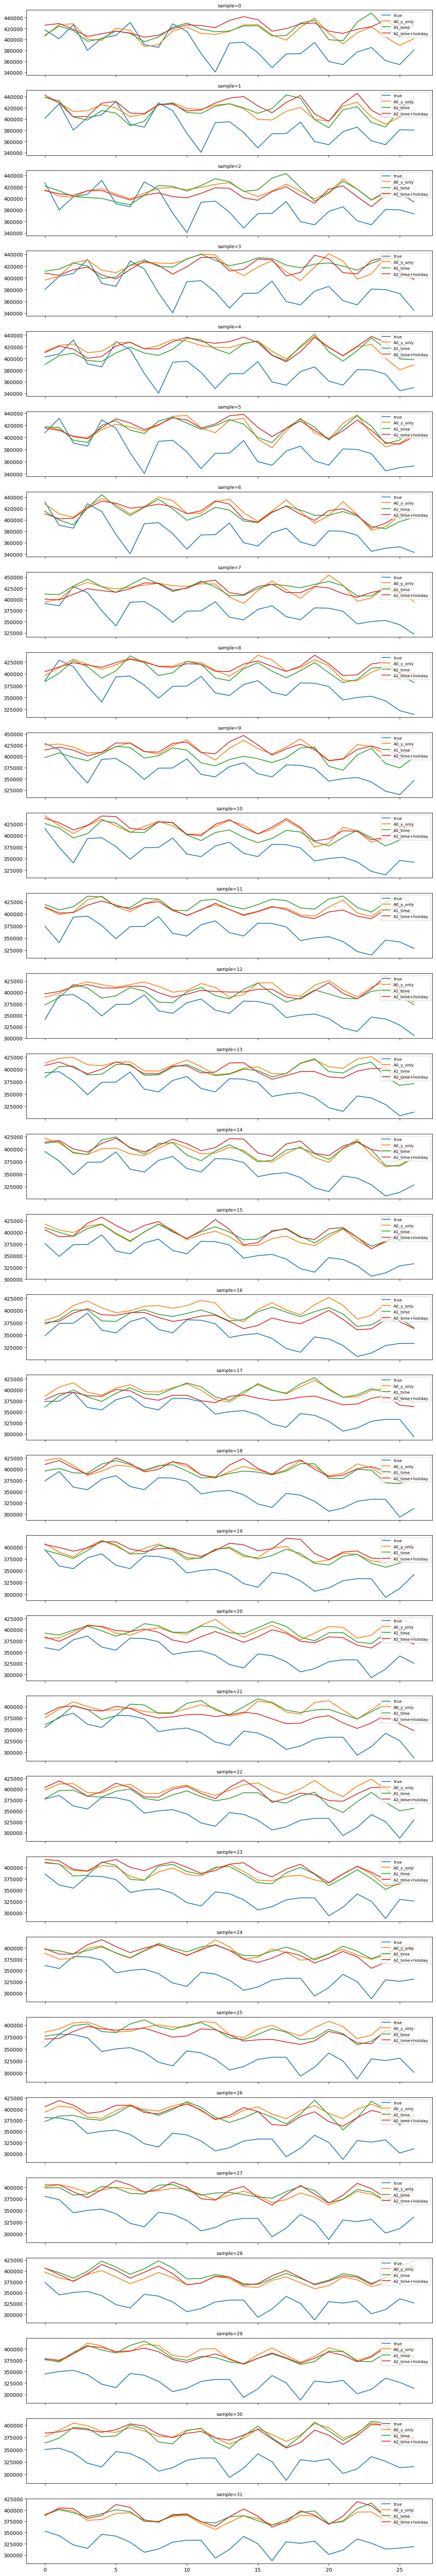

In [7]:
# ============================================
# CELL 7) (선택) 예측 시각화 (첨부 노트북 스타일)
# ============================================
import matplotlib.pyplot as plt

def plot_samples(y_true, preds: dict, max_n: int = 64):
    n = min(max_n, y_true.shape[0])
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(12, 2.2*n), sharex=True)

    if n == 1:
        axes = [axes]

    for i in range(n):
        ax = axes[i]
        ax.plot(y_true[i], label="true")
        for k, v in preds.items():
            ax.plot(v[i], label=k)
        ax.set_title(f"sample={i}", fontsize=9)
        ax.legend(loc="upper right", fontsize=8)

    plt.tight_layout()
    plt.show()

plot_samples(
    y_true=y0,
    preds={
        "A0_y_only": yhat0,
        "A1_time": yhat1,
        "A2_time+holiday": yhat2,
    },
    max_n=32,
)